# Q2: ViT for classification

## data preprocess

In [1]:
import os
import pandas as pd
from PIL import Image
import xmltodict
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = Image.open(os.path.join(folder, filename))
        if img is not None:
            images.append((filename, img))
    return images

directories = {
    'neutrophil': './data/BCCD/neutrophil',
    'eosinophil': './data/BCCD/eosinophil',
    'monocyte': './data/BCCD/monocyte',
    'lymphocyte': './data/BCCD/lymphocyte'
}

data = []
for label, folder in directories.items():
    imgs = load_images_from_folder(folder)
    for img in imgs:
        data.append((label, img[0], img[1]))

df = pd.DataFrame(data, columns=['label', 'filename', 'image'])

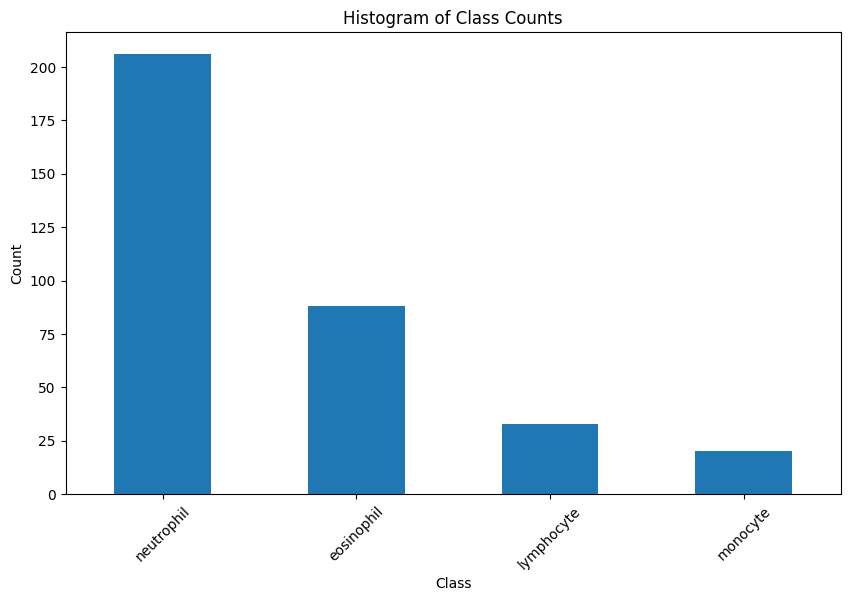

In [4]:
import matplotlib.pyplot as plt

class_counts = df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [5]:
import albumentations as A
from albumentations.core.bbox_utils import convert_bboxes_to_albumentations, convert_bboxes_from_albumentations
from albumentations.pytorch import ToTensorV2
import cv2

transform = A.Compose(
    [
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
    ]
)

In [6]:
augmented_data = []

for class_name, count in class_counts.items():
    class_samples = df[df['label'] == class_name]
    
    while sum(1 if (x['label']==class_name) else 0 for x in augmented_data)<(250 - count):
        sample = class_samples.sample(n=1).iloc[0]
        image_path = os.path.join('./data/bccd', sample['label'],sample['filename'])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        category_ids = [0]

        augmented = transform(image=image, category_ids=category_ids)
        augmented_image = augmented['image']

        augmented_data.append({
            'label': class_name,
            'filename': f"aug_{len(augmented_data)}_{sample['filename']}.jpg",
            'image': augmented_image,
        })


In [7]:
augmented_df = pd.DataFrame(augmented_data)
augmented_df = pd.concat([df, augmented_df], ignore_index=True)

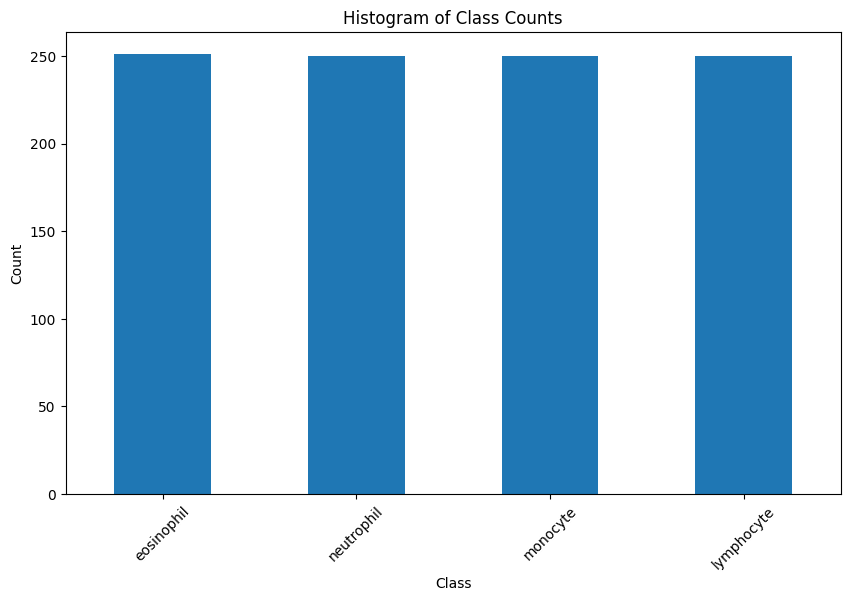

In [8]:
class_counts = augmented_df['label'].value_counts()

plt.figure(figsize=(10, 6))
class_counts.plot(kind='bar')
plt.title('Histogram of Class Counts')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
class WBCDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        img = self.df.iloc[idx]['image']
        label = self.df.iloc[idx]['label']
        
        if self.transform:
            img = self.transform(img)
        
        return img, label

In [10]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(augmented_df, test_size=0.2, random_state=42, stratify=augmented_df['label'])

In [11]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224))
])

train_dataset = WBCDataset(train_df, transform=transform)
test_dataset = WBCDataset(test_df, transform=transform)

## Model

In [12]:
from transformers import ViTFeatureExtractor
from torchvision import transforms
from PIL import Image
import torch

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224')

c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\transformers\models\vit\feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [13]:
from transformers import ViTForImageClassification

model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)
model.eval()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTSdpaAttention(
            (attention): ViTSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fe

In [22]:
train_data_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
test_data_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [15]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = model(pixel_values=imgs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions)
    ground_truth.extend(labels)

In [18]:
label_mapping = {label: idx for idx, label in enumerate(augmented_df['label'].unique())}

In [19]:
from sklearn.metrics import classification_report

print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  neutrophil       1.00      0.02      0.04        50
  eosinophil       0.11      0.08      0.09        51
    monocyte       0.00      0.00      0.00        50
  lymphocyte       0.29      0.94      0.44        50

    accuracy                           0.26       201
   macro avg       0.35      0.26      0.14       201
weighted avg       0.35      0.26      0.14       201



c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\arian\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

## Training Classifier

In [28]:
classifier_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)

for name, param in classifier_ft_model.named_parameters():
    if "classifier" not in name:
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in classifier_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


classifier.weight is trainable.
classifier.bias is trainable.


In [30]:
from torch.optim import Adam

optimizer = Adam([{'params': classifier_ft_model.classifier.parameters(), 'lr': 1e-4},], lr=1e-4)

classifier_ft_model.train()

num_epochs = 10
for epoch in range(num_epochs):
    for batch in train_data_loader:
        images, labels = batch        
        optimizer.zero_grad()

        outputs = classifier_ft_model(pixel_values=images, labels=torch.tensor([label_mapping[i] for i in labels]))
        
        loss = outputs.loss        
        loss.backward()        
        optimizer.step()
            
    print(f"Epoch {epoch + 1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.3628612756729126
Epoch 2, Loss: 1.2767224311828613
Epoch 3, Loss: 1.2046312093734741
Epoch 4, Loss: 1.1449741125106812
Epoch 5, Loss: 1.0946063995361328
Epoch 6, Loss: 1.0513287782669067
Epoch 7, Loss: 1.0135787725448608
Epoch 8, Loss: 0.9802276492118835
Epoch 9, Loss: 0.9504493474960327
Epoch 10, Loss: 0.923628032207489


In [31]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = classifier_ft_model(pixel_values=imgs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions)
    ground_truth.extend(labels)

In [33]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

              precision    recall  f1-score   support

  neutrophil       0.78      0.84      0.81        50
  eosinophil       0.67      0.63      0.65        51
    monocyte       0.86      0.76      0.81        50
  lymphocyte       0.80      0.88      0.84        50

    accuracy                           0.78       201
   macro avg       0.78      0.78      0.78       201
weighted avg       0.78      0.78      0.77       201



In [34]:
total_params = sum(p.numel() for p in classifier_ft_model.parameters())

trainable_params = sum(p.numel() for p in classifier_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 3076


## first 2 layers

In [45]:
first2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)

for name, param in first2_ft_model.named_parameters():
    if ("vit.encoder.layer.0" not in name) and ("vit.encoder.layer.1" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in first2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.0.attention.attention.query.weight is trainable.
vit.encoder.layer.0.attention.attention.query.bias is trainable.
vit.encoder.layer.0.attention.attention.key.weight is trainable.
vit.encoder.layer.0.attention.attention.key.bias is trainable.
vit.encoder.layer.0.attention.attention.value.weight is trainable.
vit.encoder.layer.0.attention.attention.value.bias is trainable.
vit.encoder.layer.0.attention.output.dense.weight is trainable.
vit.encoder.layer.0.attention.output.dense.bias is trainable.
vit.encoder.layer.0.intermediate.dense.weight is trainable.
vit.encoder.layer.0.intermediate.dense.bias is trainable.
vit.encoder.layer.0.output.dense.weight is trainable.
vit.encoder.layer.0.output.dense.bias is trainable.
vit.encoder.layer.0.layernorm_before.weight is trainable.
vit.encoder.layer.0.layernorm_before.bias is trainable.
vit.encoder.layer.0.layernorm_after.weight is trainable.
vit.encoder.layer.0.layernorm_after.bias is trainable.
vit.encoder.layer.1.attention.at

In [46]:
total_params = sum(p.numel() for p in first2_ft_model.parameters())

trainable_params = sum(p.numel() for p in first2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 28351488


In [ ]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = first2_ft_model(pixel_values=imgs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions)
    ground_truth.extend(labels)

In [ ]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

## last 2 layers

In [48]:
last2_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)

for name, param in last2_ft_model.named_parameters():
    if ("vit.encoder.layer.10" not in name) and ("vit.encoder.layer.11" not in name):
        param.requires_grad = False
    else:
        param.requires_grad = True


for name, param in last2_ft_model.named_parameters():
    if param.requires_grad:
        print(f"{name} is trainable.")

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


vit.encoder.layer.10.attention.attention.query.weight is trainable.
vit.encoder.layer.10.attention.attention.query.bias is trainable.
vit.encoder.layer.10.attention.attention.key.weight is trainable.
vit.encoder.layer.10.attention.attention.key.bias is trainable.
vit.encoder.layer.10.attention.attention.value.weight is trainable.
vit.encoder.layer.10.attention.attention.value.bias is trainable.
vit.encoder.layer.10.attention.output.dense.weight is trainable.
vit.encoder.layer.10.attention.output.dense.bias is trainable.
vit.encoder.layer.10.intermediate.dense.weight is trainable.
vit.encoder.layer.10.intermediate.dense.bias is trainable.
vit.encoder.layer.10.output.dense.weight is trainable.
vit.encoder.layer.10.output.dense.bias is trainable.
vit.encoder.layer.10.layernorm_before.weight is trainable.
vit.encoder.layer.10.layernorm_before.bias is trainable.
vit.encoder.layer.10.layernorm_after.weight is trainable.
vit.encoder.layer.10.layernorm_after.bias is trainable.
vit.encoder.laye

In [50]:
total_params = sum(p.numel() for p in last2_ft_model.parameters())

trainable_params = sum(p.numel() for p in last2_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 14175744


In [ ]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = last2_ft_model(pixel_values=imgs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions)
    ground_truth.extend(labels)

In [ ]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))

## all layers

In [51]:
all_ft_model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224', num_labels=4, ignore_mismatched_sizes=True)

for name, param in all_ft_model.named_parameters():
    param.requires_grad = True

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [52]:
total_params = sum(p.numel() for p in all_ft_model.parameters())

trainable_params = sum(p.numel() for p in all_ft_model.parameters() if p.requires_grad)

print(f"Total parameters: {total_params}")
print(f"Trainable parameters: {trainable_params}")

Total parameters: 85801732
Trainable parameters: 85801732


In [ ]:
predictions = []
ground_truth = []

for batch in test_data_loader:
    imgs, labels = batch

    with torch.no_grad():
        outputs = all_ft_model(pixel_values=imgs)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=1)

    predictions.extend(batch_predictions)
    ground_truth.extend(labels)

In [ ]:
print(classification_report([label_mapping[i] for i in ground_truth], predictions, target_names=label_mapping))